### Imports

In [1]:
include("layers.jl")
include("utils.jl")
using .Utils, .Layers

using Flux
using LightGraphs
using Colors
using Makie
using BSON: @load

### Model definition

Copy here the `make_vae()` function defined in the script that generated the model we're reloading.

In [2]:
function make_vae(;g, feature_size, args)
    diml1, dimξadj, dimξfeat, overlap = args["diml1"], args["dimxiadj"], args["dimxifeat"], args["overlap"]

    # Encoder
    l1 = Layers.GC(g, feature_size, diml1, Flux.relu, initb = Layers.nobias)
    lμ = Layers.Apply(Layers.VOverlap(overlap),
        Layers.GC(g, diml1, dimξadj, initb = Layers.nobias),
        Layers.GC(g, diml1, dimξfeat, initb = Layers.nobias))
    llogσ = Layers.Apply(Layers.VOverlap(overlap),
        Layers.GC(g, diml1, dimξadj, initb = Layers.nobias),
        Layers.GC(g, diml1, dimξfeat, initb = Layers.nobias))
    enc(x) = (h = l1(x); (lμ(h), llogσ(h)))

    # Sampler
    sampleξ(μ, logσ) = μ .+ exp.(logσ) .* randn_like(μ)

    # Decoder
    decadj = Chain(
        Dense(dimξadj, diml1, Flux.relu, initb = Layers.nobias),
        Layers.Bilin(diml1)
    )
    decfeat = Chain(
        Dense(dimξfeat, diml1, Flux.relu, initb = Layers.nobias),
        Dense(diml1, feature_size, initb = Layers.nobias),
    )
    @views dec(ξ) = (decadj(ξ[1:dimξadj, :]), decfeat(ξ[end-dimξfeat+1:end, :]))

    enc, sampleξ, dec, Flux.params(l1, lμ, llogσ), Flux.params(decadj, decfeat)
end

make_vae (generic function with 1 method)

### Plotting model state

In [3]:
adims(a, dims) = [a[i, :] for i = dims]

function plotstate(;enc, vae, x, refx, g, dims)
    @assert length(dims) in [2, 3]
    embμ, emblogσ = enc(x)
    logitÂ, unormF̂ = vae(x)
    hbox(
        vbox(
            Scene(),
            heatmap(σ.(logitÂ).data, colorrange = (0, 1)),
            heatmap(1:size(x, 1), 1:size(x, 2), softmax(unormF̂).data, colorrange = (0, 1)),
            sizes = [.45, .45, .1]
        ),
        vbox(
            scatter(adims(embμ, dims)..., color = colors, markersize = markersize(embμ)),
            heatmap(Array(adjacency_matrix(g)), colorrange = (0, 1)),
            heatmap(1:size(x, 1), 1:size(x, 2), refx, colorrange = (0, 1)),
            sizes = [.45, .45, .1]
        ),
    )
end

function plotweights(layers...)
    theme = Theme(align = (:left, :bottom), raw = true, camera = campixel!)
    vbox([hbox(heatmap(l.W.data), text(theme, repr(l))) for l in layers]...)
end

plotweights (generic function with 1 method)

### Load the model and plot its state

In [4]:
@load "../dataset.bson" g labels features
@load "../weights.bson" weights args

enc, sampleξ, dec, paramsenc, paramsdec = make_vae(g = g, feature_size = size(features, 1), args = args)
vae(x) = dec(sampleξ(enc(x)...))

paramsvae = Tracker.Params()
push!(paramsvae, paramsenc..., paramsdec...)
loadparams!(paramsvae, weights)

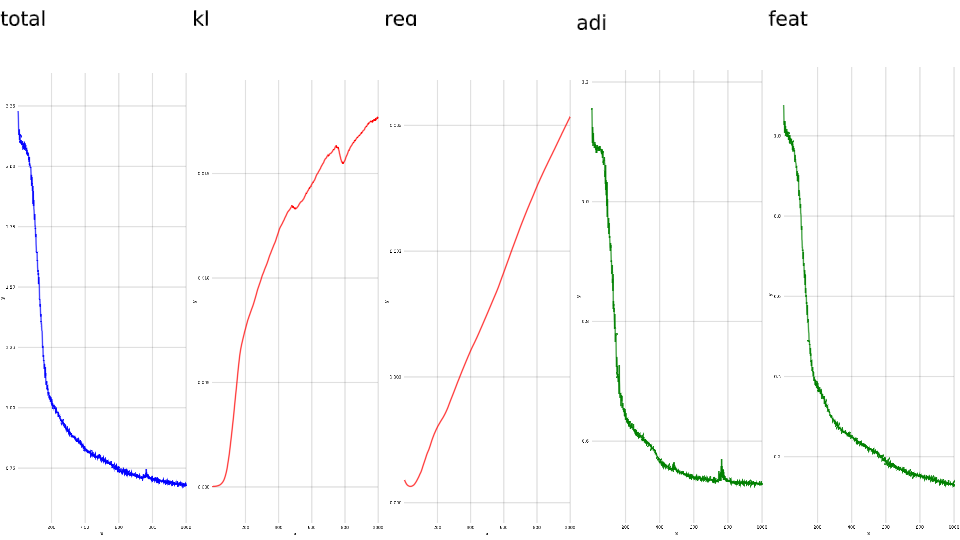

In [5]:
@load "../history.bson" history

theme = Theme(align = (:left, :bottom), raw = true, camera = campixel!)
vbox([hbox(lines(1:length(history[name]), history[name], color = color), text(theme, name))
        for (name, color) in [("total", :blue), ("kl", :red), ("reg", :red), ("adj", :green), ("feat", :green)]]...)

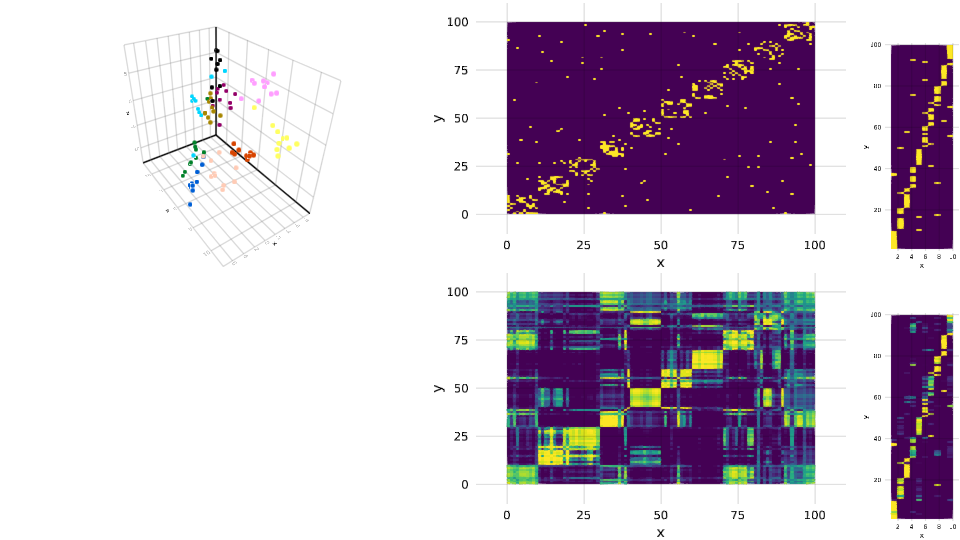

In [6]:
communities = [c for c in 1:args["l"] for i in 1:args["k"]]
palette = distinguishable_colors(args["l"])
colors = map(i -> getindex(palette, i), communities)

plotstate(enc = enc, vae = vae, x = features, refx = labels, g = g, dims = 1:3)